<a href="https://colab.research.google.com/github/SergioQS/Quantum_computing/blob/main/Reproduced_QCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Machine learning Project:** QCNN implementation
**Sergio Quiroga Sandoval \
squirogas@unal.edu.co \
Universidad Nacional de Colombia**

This project is a complete reproduction of the **pennylane** tutorials for this model at Andrea Mari: [Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution/). March 23, 2020.


Also retrieved information from **Medium** Arnaud Robin and Stanislav I Slavov:    [Implementing Quantum Convolutional Neural Networks](https://medium.com/mit-6-s089-intro-to-quantum-computing/quanvolutional-neural-networks-might-be-the-future-of-deep-learning-heres-why-5377bfc03652) Jan 27, 2022.

## Changes in this implementation from the Pennylane docs:
*We set a different dataset size and eliminate some Differences between the tutorial and the proposed model in the original paper.*\
Aiming to reproduce the model as it was proposed.


*   We will test the model on 1000 samples from MNIST dataset (They used 70000 samples and ran the model on QxBranch quantum computer simulation system).
*   Generation of the random quantum circuit. (pag 5 Quanvolutional filter generation methodology)
*   Use of a $3 \times 3$ convolution filter size, instead of $2 \times 2$ done in the tutorial.
*   





## Concepts

Classical concolutional layer

Instead of processing the full input data with a global function, a local convolution is applied.

Small local regions are sequentially processed with the same kernel. The results obtained for each region are usually associated to different channels of a single output pixel. The union of all the output pixels produces a new image-like object, which can be further processed by additional layers.

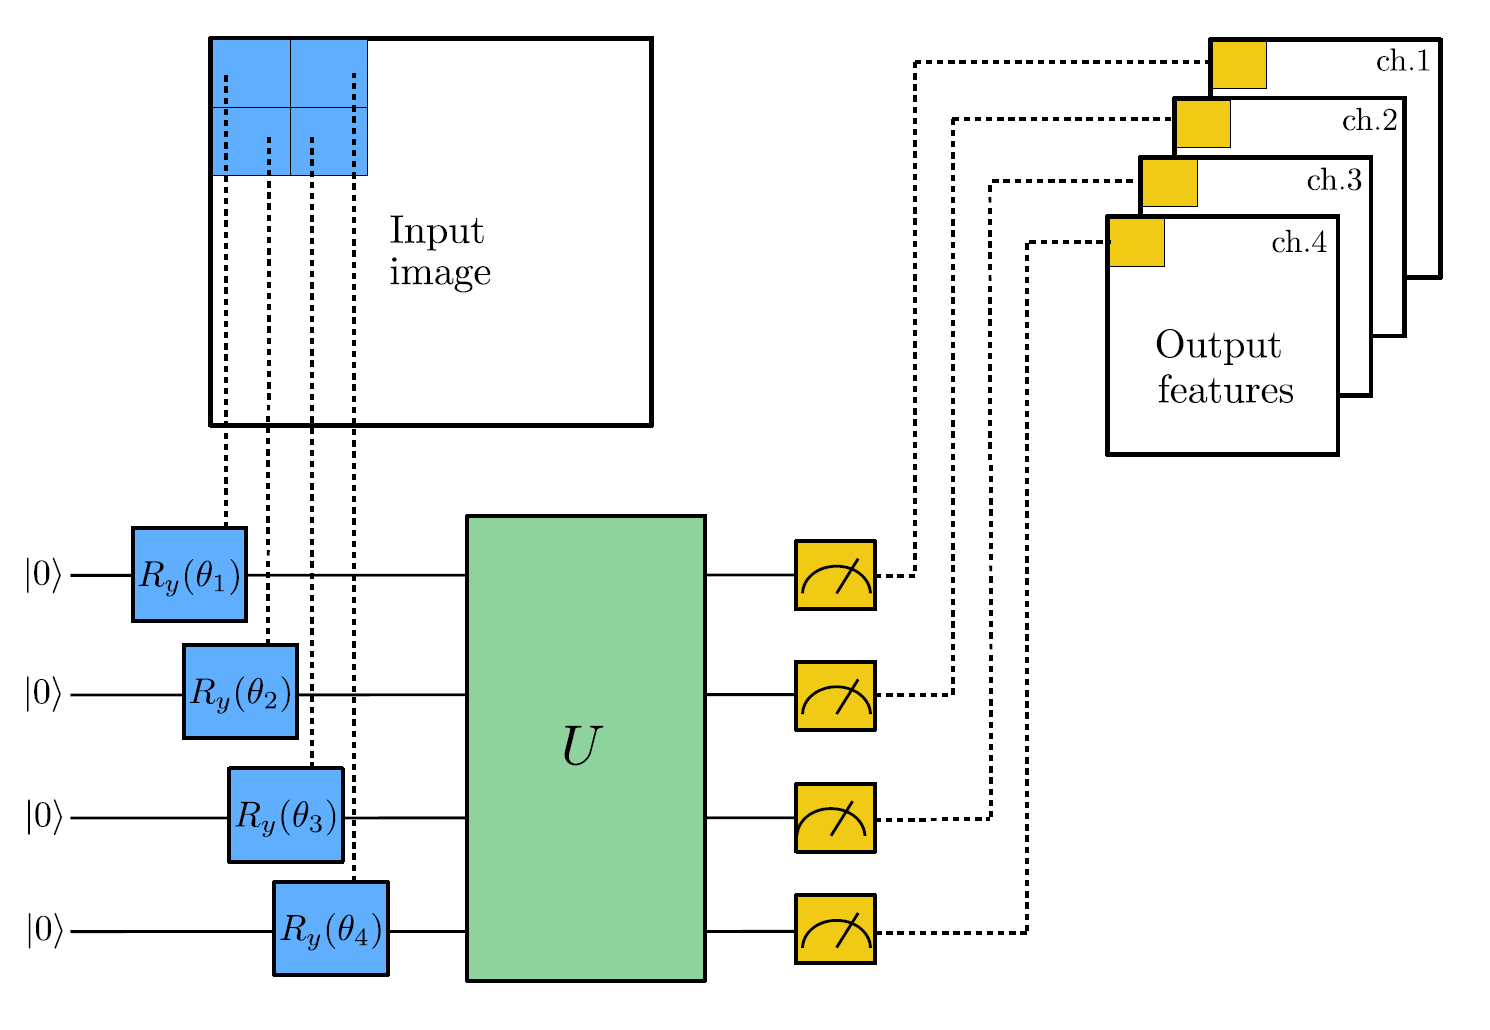

## Setup

In [18]:
!pip install pennylane

In [21]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Hyperparameters

In [22]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/data_saving_folder"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## Loading of the MNIST dataset

In [23]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Quantum circuit as a convolution kernel

In [24]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

convolution scheme

In [25]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset

In [26]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


# The data saving folder may produce an error, you can fix it by changing the SAVE_PATH from the first block of code to a new folder

Quantum pre-processing of train images:

Quantum pre-processing of test images:


visualize the effect of the quantum convolution layer on a batch of samples:

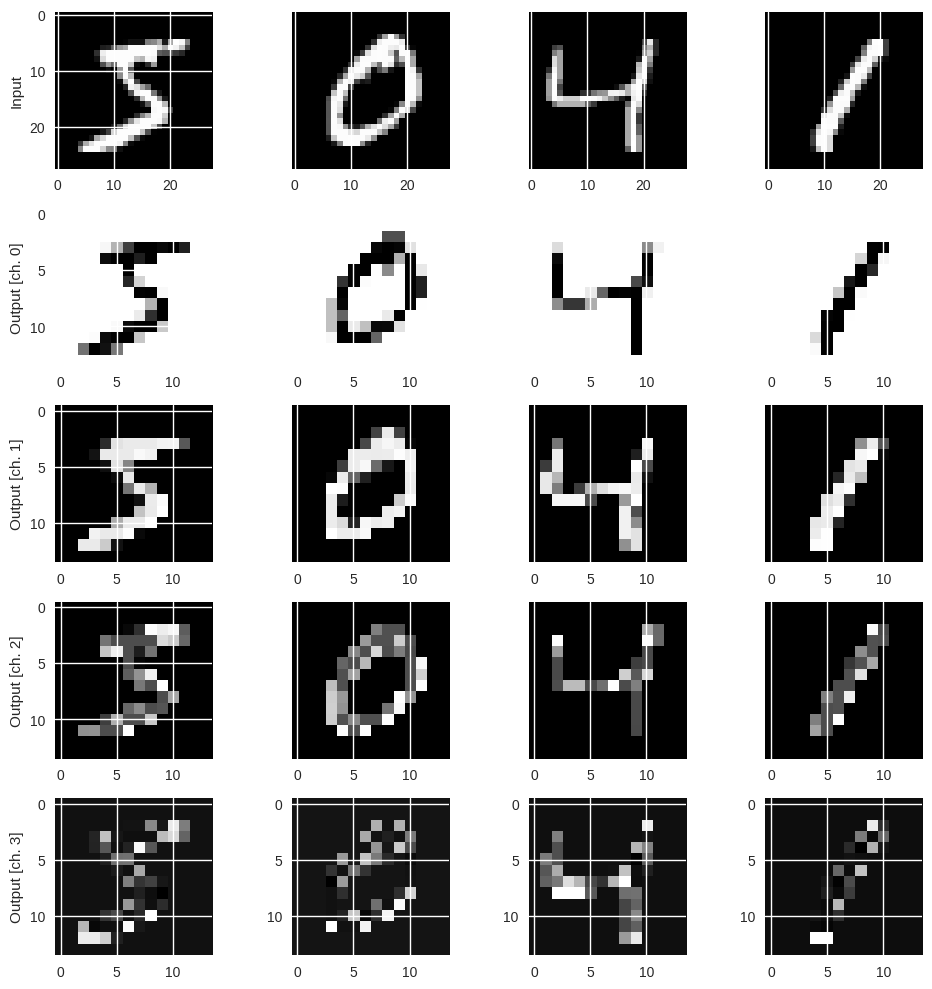

In [27]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Hybrid quantum-classical model

In [28]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training

In [29]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.6280 - accuracy: 0.1200 - val_loss: 2.2316 - val_accuracy: 0.3000 - 622ms/epoch - 48ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0617 - accuracy: 0.2400 - val_loss: 2.0234 - val_accuracy: 0.4000 - 62ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6859 - accuracy: 0.5200 - val_loss: 2.0048 - val_accuracy: 0.3667 - 76ms/epoch - 6ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3729 - accuracy: 0.6400 - val_loss: 1.7908 - val_accuracy: 0.3667 - 59ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1488 - accuracy: 0.8600 - val_loss: 1.6346 - val_accuracy: 0.4667 - 64ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9761 - accuracy: 0.8800 - val_loss: 1.6081 - val_accuracy: 0.4667 - 60ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7931 - accuracy: 0.9000 - val_loss: 1.5505 - val_accuracy: 0.5667 - 67ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6537 - accuracy: 0.9600 - val_loss: 1.4306 - val_accuracy: 0.5333 - 64ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images to compare the results achievable with and without the quantum convolution layer,

In [30]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.4858 - accuracy: 0.1000 - val_loss: 2.3287 - val_accuracy: 0.1667 - 574ms/epoch - 44ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0934 - accuracy: 0.3600 - val_loss: 2.1365 - val_accuracy: 0.2333 - 63ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7660 - accuracy: 0.5400 - val_loss: 1.9804 - val_accuracy: 0.3333 - 69ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 1.5180 - accuracy: 0.7600 - val_loss: 1.8360 - val_accuracy: 0.4333 - 67ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.3025 - accuracy: 0.7600 - val_loss: 1.6999 - val_accuracy: 0.5333 - 72ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1227 - accuracy: 0.8400 - val_loss: 1.5960 - val_accuracy: 0.5667 - 71ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9728 - accuracy: 0.8800 - val_loss: 1.5203 - val_accuracy: 0.6000 - 64ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8486 - accuracy: 0.8800 - val_loss: 1.4440 - val_accuracy: 0.6000 - 65ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

## Results


<ipython-input-31-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


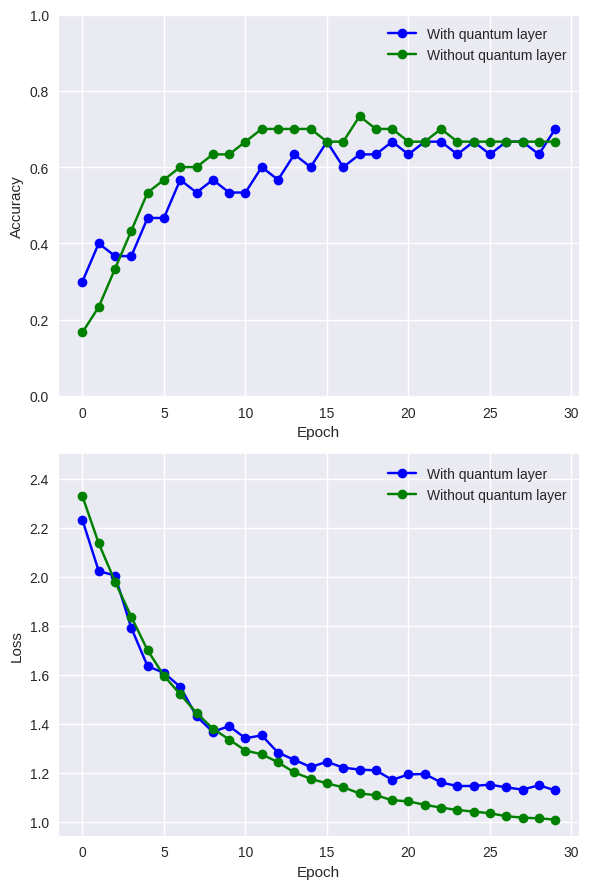

In [31]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# References



*  Andrea Mari: Quanvolutional Neural Networks. March 23, 2020. Last updated January 14, 2021.
*  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.



